# AOS_singleAmpSep

# Star Separation Test on a single Amplifier

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are brought closer together,  possibly bringing us to the regime of overlapping donuts. We ensure that stars are simulated on a single amplifier, to avoid positioning on CCD edges where some non-uniformity in donut image could be due to the instrument signature removal (ISR) process, which is in constant improvement.

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/`. 

The exact steps:

    cd /epyc/users/suberlak/Commissioning/aos/
    source setup_aos_2020_15.sh 
    cd  ts_phosim/notebooks/analysis_scripts/
    python runSingleAmpStarSep.py


### Results

In [1]:


import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import argparse

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

import matplotlib.pyplot as plt
import matplotlib.cm as cm 



In [3]:
%matplotlib inline

baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_after_centroid_update'
resDir = 'singleAmpSepNew'

#os.listdir(data_dir)

First, plot root-mean-squared difference between wavefront estimation from `ts_wep`, and the OPD (truth) : 

10
9
8
7
6
5
4
3
2
1


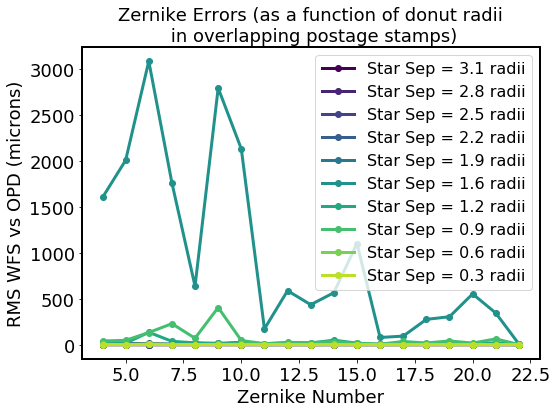

In [31]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


sepArr = np.arange(1,11)[::-1]

yPxAmp = 2048 # in pixeels
donutPxRadius = 66 # px 

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr :
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInPx = sepArr[i]*0.01*yPxAmp
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % (sepInPx / donutPxRadius),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()
# plt.savefig('StarSep_singleAmp_16mag_vary_separation_rms_wfs_vs_opd_overlapping2_in_donut.png', 
#             bbox_inches='tight', 
#            dpi=100)

Let's step through parts:  

1) those stars that are far-away have good recovery of the wavefront: 

10
9
8


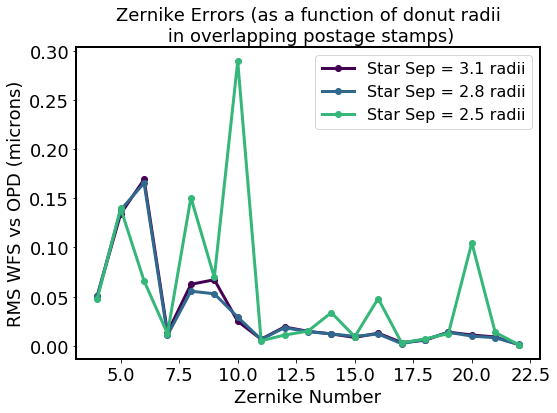

In [29]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


sepArr = [10,9,8]

yPxAmp = 2048 # in pixeels
donutPxRadius = 66 # px 

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr:
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInPx = sepArr[i]*0.01*yPxAmp
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % (sepInPx / donutPxRadius),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()
# plt.savefig('StarSep_singleAmp_16mag_vary_separation_rms_wfs_vs_opd_overlapping2_in_donut.png', 
#             bbox_inches='tight', 
#            dpi=100)

This picture from https://www.janssenprecisionengineering.com/wp-content/uploads/Zernike_modes_adapted.png illustrates which optical distortions these Zernikes correspond: 
    <img src='Zernike_modes_adapted.png'></img>

Plot wfs error for each star separation as well as postISR image to illustrate, for a particular intra-focal sensor

In [32]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase


obsId = 9006001 # intra-focal
detNum = 90

detectorNames = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
detectorName = detectorNames[0]

# Read each figure as a postage stamp, store data to an array 
images = {}
for sep in sepArr:
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    print('\nReading data from')
    print(data_dir)
    repo_dir = os.path.join(data_dir, 'input/rerun/run1')
    butler = dafPersist.Butler(repo_dir)
    
    data_id = {'visit': obsId, 'filter': 'g', 'raftName': 'R22', 
               'detectorName': detectorName, 'detector': detNum}
    post = butler.get('postISRCCD', **data_id) 
    
    # store in a dictionary
    images[sep] = post.image.array
    
    


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_10

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_9

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_8

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_7

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_6

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_5

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid

/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packag

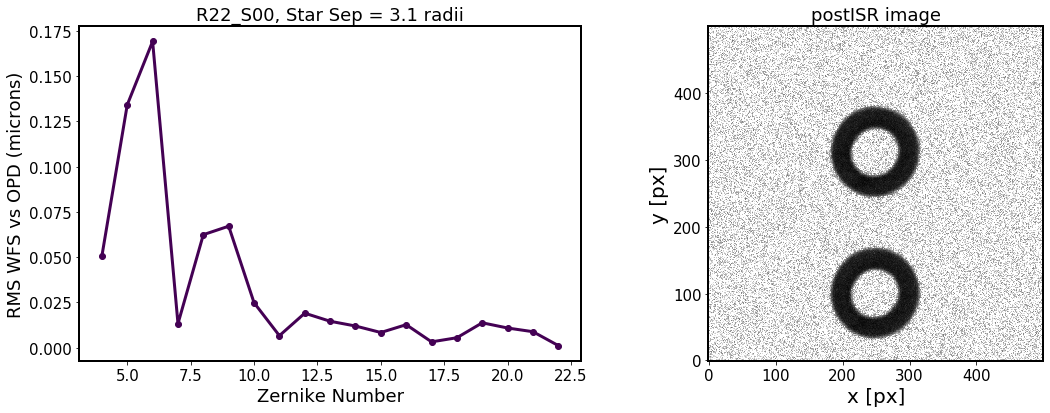

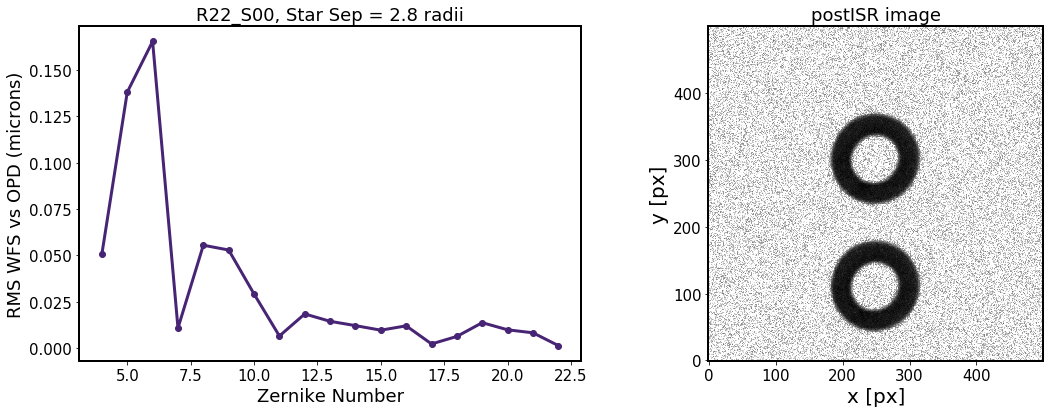

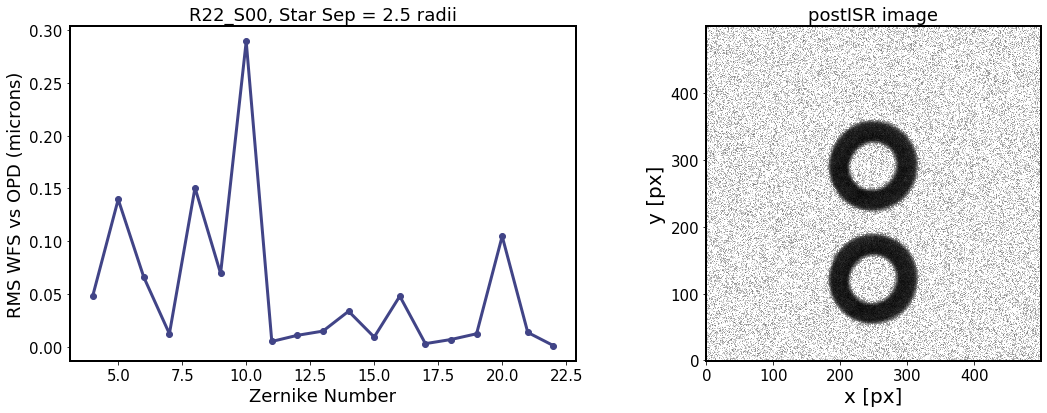

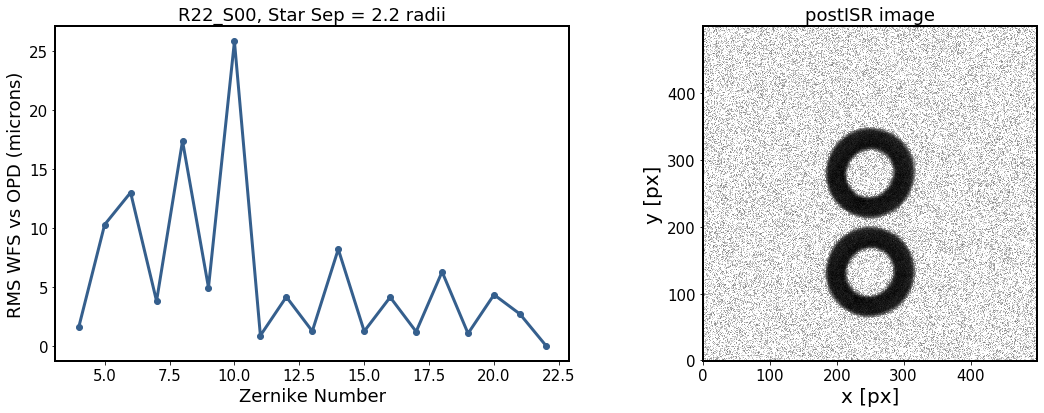

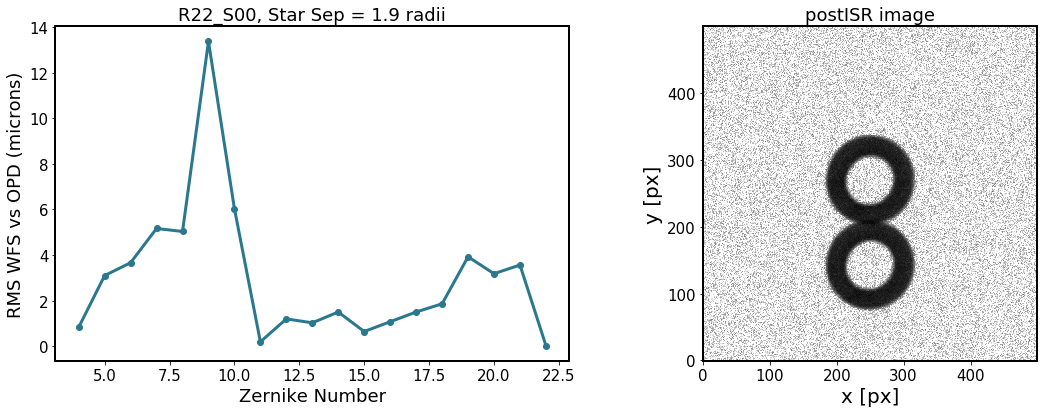

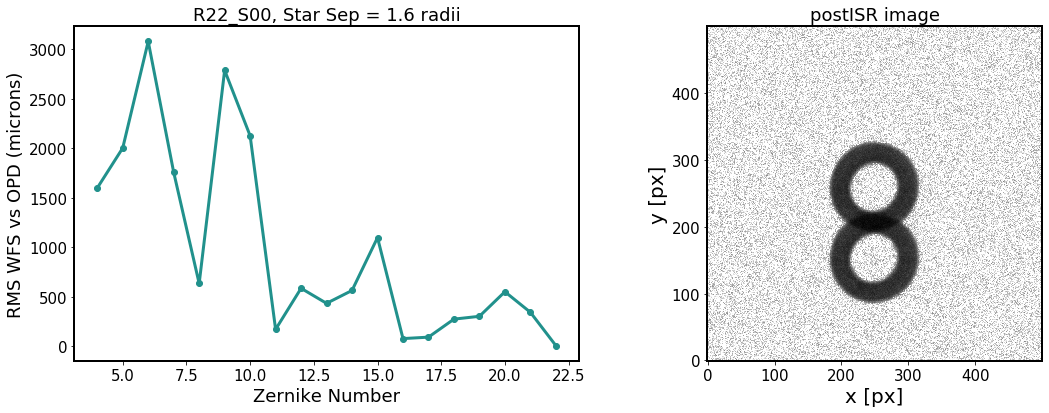

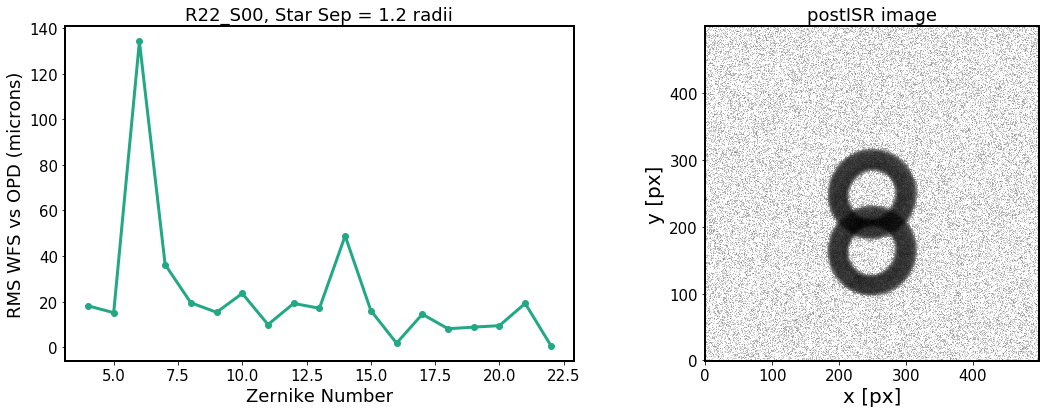

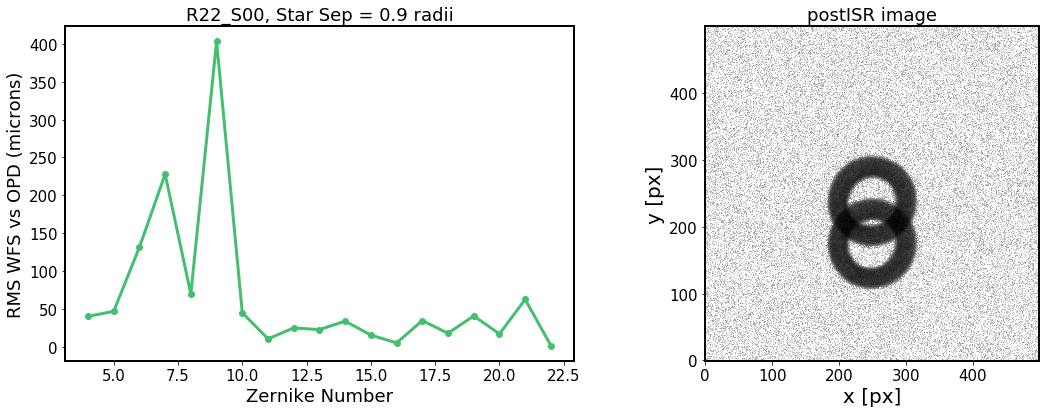

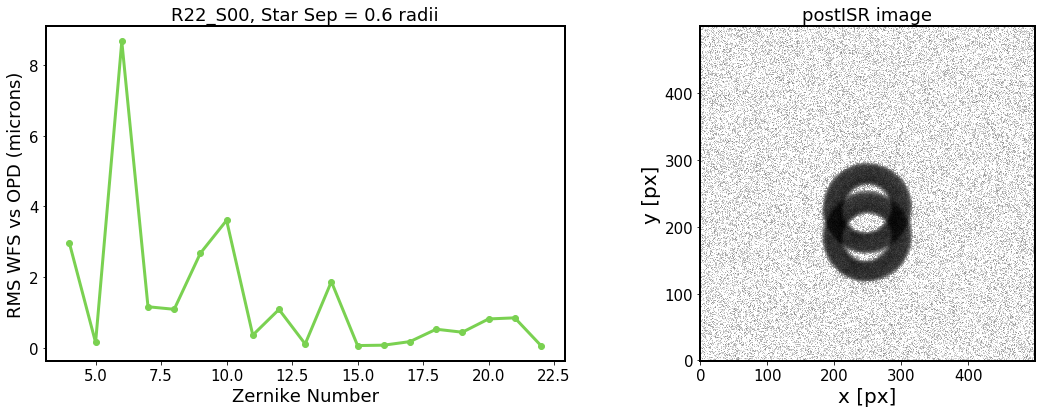

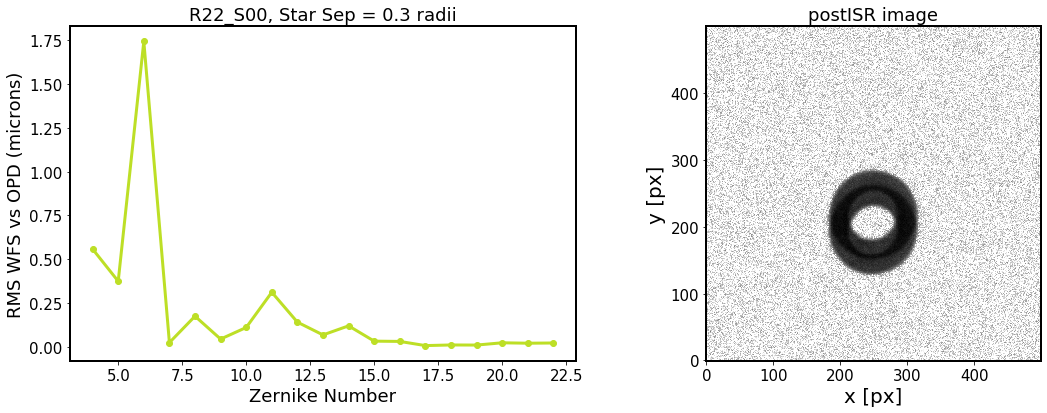

In [33]:

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



# print Zernikes and image data 

# select the actual donut position...
xmin,xmax = 1525,2025
ymin,ymax = 750,1250

#  plot the Zernikes 
for i in range(len(sepArr)):
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    sepInPx = sepArr[i]*0.01*yPxAmp
    
    
    ax[0].plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, color = cmap(colors[i]))

    ax[0].set_xlabel('Zernike Number', size=18)
    ax[0].set_ylabel('RMS WFS vs OPD (microns)', size=18)
    ax[0].set_title('R22_%s, Star Sep = %.1f radii' % (detectorName,sepInPx / donutPxRadius), size=18)
    
    # plot the postage stamp
    img = ax[1].imshow(np.log10(images[sepArr[i]][ymin:ymax, xmin:xmax]), vmin = 0.01,
                       cmap=cm.get_cmap('Greys'),
              origin='lower')
    #cbar= colorbar(mappable=img)
    #cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    ax[1].set_title('postISR image')
    plt.tight_layout()
    plt.savefig('img_AOS_singleAmpSep_postIsr_sep%d.png'%sepArr[i],bbox_inches='tight',
               dpi=150)

Plot the entire R22_S00 sensor (all CCDs)  for 5\% of amplifier span:

In [ ]:
# Read in the postISR image using the Butler 

focalType = 'extra'  # choose whether extra or intra focal image
obsIdDic = {'intra':9006001,  'extra':9006002} 
obsId = obsIdDic[focalType]

detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R22'
detector = 'S00'

sensor = raft+'_'+detector 

detNumDict = {'S00':90, 'S01':91, 'S02':92, 'S10':93, 'S11':94, 'S12':95, 'S20':96, 'S21':97, 'S22':98}
detNum = detNumDict[detector]

data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 'detectorName': detector, 'detector': detNum}


# Read each figure as a postage stamp, store data to an array 
images = {}


data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)


print('\nReading data from')
print(dataDir)
print('For sensor %s '%sensor)
repo_dir = os.path.join(data_dir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

# show what keys are needed by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int, 'filter': str,'raftName': str, 'detectorName': str, 'detector': int}
post = butler.get('postISRCCD', **data_id) 

# store in a dictionary
images[sensor] = post.image.array

    

In [ ]:
%matplotlib inline
# print the entire CCD R22_S01 postISR image data :  for gMagGt11_....

# print the entire CCD R22_S02  postISR,  for gMagGt11_w_2020_15_convolveTemplate...

    
# helper funtion for the colorbar 
# from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar



fig, ax = plt.subplots(1,1,figsize=(10,10))

# plot the postage stamp
img = ax.imshow(np.log10(images[sensor].T), vmin = 2.45, vmax=2.75,
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('postISR image, sensor %s, %s-focal'%(sensor,focalType))

m1 = postage['abbrevDetectorName'] == sensor
m2 = postage['focalPlane'] == focalType
mask = m1 * m2 
for i in range(len(postage[mask])):
    x,y = postage[mask]['xpos'][i], postage[mask]['ypos'][i]
    starId = postage[mask]['starId'][i]
    ax.plot(x,y, 's', markersize=40, markerfacecolor='none',
             markeredgewidth=2.5, markeredgecolor='y')
    ax.text(x-140, y+200, starId, fontsize=14, color='white')
    
    # get the centroid location for that star
    starCentr = centr[centr['SourceID'].data.astype(int) == starId]
    xCen, yCen = starCentr['AvgX'].data  , starCentr['AvgY'].data 
    # plot it with a cross 
    ax.plot(xCen, yCen, '+', markersize=20, markeredgecolor='red', markerfacecolor='red',
           markeredgewidth=2)
    
focalType = 'extra'
convDir = os.path.join(dataDir, 'iter0','img',focalType)
print('Reading centroid files from %s'%convDir)
obsId = 9006001
fname = 'centroid_lsst_e_%d_f1_R22_S02_E000.txt'%obsId
print('From filename %s'%fname)
centr = Table.read(convDir+'/'+fname, format='ascii')


plt.tight_layout()


TypeError: 'AxesImage' object is not subscriptable